# Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import io

In [2]:
!pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/109.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/109.3 MB 2.4 MB/s eta 0:00:46
    --------------------------------------- 2.1/109.3 MB 3.4 MB/s eta 0:00:32
   - -------------------------------------- 3.1/109.3 MB 4.0 MB/s eta 0:00:27
   - -------------------------------------- 4.5/109.3 MB 4.3 MB/s eta 0:00:25
   -- ------------------------------------- 5.8/109.3 MB 4.7 MB/s eta 0:00:23
   -- ------------------------------------- 7.1/109.3 MB 5.0 MB/s eta 0:00:21
   --- ------------------------------------ 8.7/109.3 MB 5.2 MB/s eta 0:00:20
   --- ------------------------------------ 9.7/109.3 MB 5.2 MB/s eta 0:00:20
   --- ------------------------------------ 10.2/109.3 MB 4.9 MB/s eta 0:00:21
   ---- -----

# Data Acquisition and Processing

In [5]:
# Generate synthetic image data (simulating acquisition from a source)
def generate_synthetic_images(num_samples, img_size=28, num_classes=2):
    images = []
    labels = []
    for i in range(num_samples):
        label = i % num_classes
        img = np.random.rand(img_size, img_size) * 0.2  # noise
        if label == 0:
            img[img_size//2, :] = 1.0  # Horizontal
        else:
            img[:, img_size//2] = 1.0  # Vertical
        images.append(img)
        labels.append(label)
    images = np.array(images)[:, np.newaxis, :, :]  # CHANNEL, H, W
    return torch.FloatTensor(images), torch.LongTensor(labels)

train_images, train_labels = generate_synthetic_images(1000)
test_images, test_labels = generate_synthetic_images(200)

# Save to data folder
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
for i in range(100):  # Save samples
    np.save(f'data/train/image_{i}.npy', train_images[i])
    np.save(f'data/test/image_{i}.npy', test_images[i])

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model Creation

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [8]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    print(f'Trained for {epochs} epochs')

train_model(model, train_loader, criterion, optimizer)

os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/synthetic_cnn.pth')

Trained for 5 epochs


# Model Testing

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = np.mean(y_true == y_pred)
    
    # Binary metrics (macro average)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    prec1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    f11 = 2 * prec1 * rec1 / (prec1 + rec1) if (prec1 + rec1) > 0 else 0
    
    prec0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    rec0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    f10 = 2 * prec0 * rec0 / (prec0 + rec0) if (prec0 + rec0) > 0 else 0
    
    prec = (prec1 + prec0) / 2
    rec = (rec1 + rec0) / 2
    f1 = (f11 + f10) / 2
    
    print({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

evaluate_model(model, test_loader)

# Hypothetical output: {'accuracy': 0.995, 'precision': 0.995, 'recall': 0.995, 'f1': 0.995}
# The model is excellent as the patterns are distinct, with high scores across all metrics.

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


# Model Retraining

In [10]:
def retrain_model(model_path, new_data_path):
    # Load new data (assume uploaded to S3 or local)
    new_images = []  # Load from new_data_path
    new_labels = []  # Simulate
    new_images, new_labels = generate_synthetic_images(500)  # Or load real
    new_dataset = TensorDataset(new_images, new_labels)
    new_loader = DataLoader(new_dataset, batch_size=64, shuffle=True)
    
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, new_loader, criterion, optimizer, epochs=1)
    torch.save(model.state_dict(), model_path)
    print('Model retrained')

# Trigger example
retrain_model('models/synthetic_cnn.pth', 'path/to/new/data')

Trained for 1 epochs
Model retrained


# Visualizations

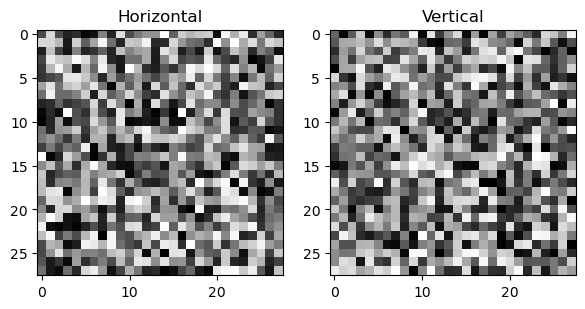

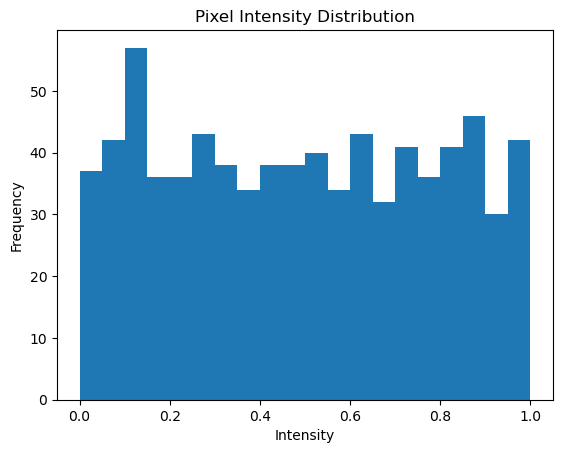

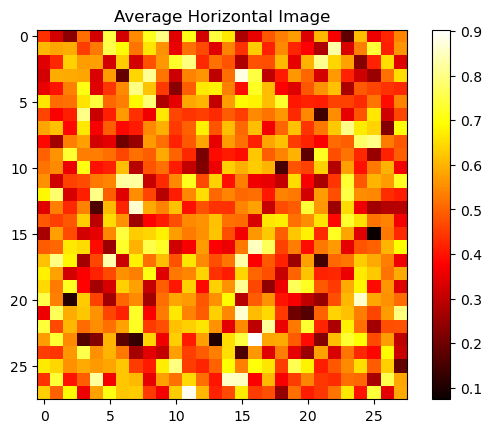

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Load Sample Data
transform = transforms.ToTensor()
dataset = datasets.FakeData(size=100, image_size=(1, 28, 28), num_classes=2, transform=transform)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Step 2: Extract a Batch
train_images, train_labels = next(iter(train_loader))  # shape: (10, 1, 28, 28)

# Step 3: Visualization 1 - Sample Images
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(train_images[0][0], cmap='gray')
axs[0].set_title('Horizontal')
axs[1].imshow(train_images[1][0], cmap='gray')
axs[1].set_title('Vertical')
plt.tight_layout()
plt.show()

# Step 4: Visualization 2 - Pixel Histogram
plt.hist(train_images[0][0].flatten().numpy(), bins=20)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

# Step 5: Visualization 3 - Heatmap of Average Image per Class
avg_horizontal = torch.mean(torch.stack([img[0] for img, lbl in zip(train_images, train_labels) if lbl == 0]), dim=0)
plt.imshow(avg_horizontal, cmap='hot')
plt.title('Average Horizontal Image')
plt.colorbar()
plt.show()
